In [3]:
import numpy as np

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

from boruta import BorutaPy


In [4]:
def save_features(file_name: str, features: list[tuple[str, float]]) -> None:
    with open(f"{file_name}.txt", "w") as file:
        for feature in features:
            print(feature[0], file=file)


In [12]:
def extract_feature_numbers(file_path):
    feature_numbers = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Strip leading/trailing whitespace and split on ' '
            parts = line.strip().split()
            # The number is the second part of the split line
            if len(parts) == 2 and parts[0] == "feature":
                try:
                    feature_numbers.append(int(parts[1]))
                except ValueError:
                    continue  # Skip lines where the second part is not an integer
    
    return feature_numbers

In [5]:
x_train_path = "../data/x_train.txt"
y_train_path = "../data/y_train.txt"

x_data = np.loadtxt(x_train_path, delimiter=' ')
y_data = np.loadtxt(y_train_path, delimiter=' ')

print("X shape:", x_data.shape)
print("Y shape:", y_data.shape)


X shape: (5000, 500)
Y shape: (5000,)


In [6]:
print("Y == 1:", sum([1 for record in y_data if record == 1]))
print("Y == 0:", sum([1 for record in y_data if record == 0]))


Y == 1: 2496
Y == 0: 2504


In [7]:
from sklearn.preprocessing import MinMaxScaler

standard_scaler = MinMaxScaler(feature_range=(0, 1))
x_data_standardized = standard_scaler.fit_transform(x_data, y_data)


In [6]:
from sklearn.preprocessing import PolynomialFeatures

polunomial_builder = PolynomialFeatures()
x_df_poly = polunomial_builder.fit_transform(x_data_standardized)

print("X polynomialed shape:", x_df_poly.shape)


X polynomialed shape: (5000, 125751)


# Standarized RFC

In [7]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(x_data_standardized.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(x_data_standardized, y_data)
feature_importances = forest.feature_importances_

forest_importances = {
    feature_names[i]: feature_importances[i]
    for i in range(len(feature_names))
}

sorted_features = sorted(
    forest_importances.items(),
    key=lambda x:x[1],
    reverse=True
)

the_best_features = sorted_features[:20]

save_features(f"standarized_rfc_{len(the_best_features)}", the_best_features)


# Polynomialed RFC

In [8]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(x_df_poly.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(x_df_poly, y_data)
feature_importances = forest.feature_importances_

forest_importances = {
    feature_names[i]: feature_importances[i]
    for i in range(len(feature_names))
}

sorted_features = sorted(
    forest_importances.items(),
    key=lambda x:x[1],
    reverse=True
)

the_best_features = sorted_features[:20]

save_features(f"polynomialed_rfc_{len(the_best_features)}", the_best_features)


# Standarized Boruta

In [8]:
from sklearn.ensemble import RandomForestClassifier

def boruta_selection(X, y):
    rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
    boruta_model = BorutaPy(rf, n_estimators="auto")
    boruta_model.fit(X, y)

    feature_names = [f"feature {i}" for i in range(x_data_standardized.shape[1])]
    feature_importances = boruta_model.support_

    the_best_features = [
        (feature_names[i], 1.0)
        for i in range(len(feature_names))
        if feature_importances[i] == True
    ]

    return the_best_features

the_best_features = boruta_selection(x_data_standardized, y_data)

save_features(
    f"standarized_boruta_{len(the_best_features)}",
    the_best_features
    )

# Standarized KBest

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif

select_k_best = SelectKBest(score_func=f_classif, k=10)
X_new = select_k_best.fit_transform(x_data_standardized, y_data)
selected_features_kbest = select_k_best.get_support(indices=True)
selected_features_names_kbest = [(f"feature {i}", 1) for i in selected_features_kbest]

save_features(
    f"standarized_kbest_{len(the_best_features)}",
    the_best_features
    )


# Standarized Lasso

In [13]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(x_data_standardized, y_data)
selected_features_lasso = np.where(lasso.coef_ != 0)[0]
selected_features_names_lasso = [f"feature {i}" for i in selected_features_lasso]

save_features(
    f"standarized_lasso_{len(the_best_features)}",
    the_best_features
    )


## Boruta + Correlation Feature Selection

In [34]:
feature_numbers = extract_feature_numbers('standarized_boruta_10.txt')
new_X_standarized = x_data_standardized[:, feature_numbers]
new_X_standarized.shape

(5000, 10)

Correlated features to delete: {1, 2, 3, 5, 7}


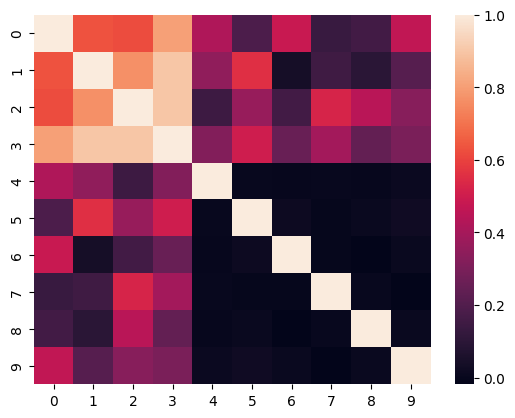

In [35]:
import seaborn as sns
import pandas as pd

def CFS(df, threshold=0.5, show=True):
    feature_corr = set()  
    corr_matrix = df.corr()
    
    if show:
        sns.heatmap(corr_matrix)

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # absolute coeff value
            if abs(corr_matrix.iloc[i, j]
                   ) > threshold:  
                # getting the name of column
                colname = corr_matrix.columns[i]  
                feature_corr.add(colname)
    
    if show:    
        print(f'Correlated features to delete: {feature_corr}')
    
    return feature_corr


feature_corr = CFS(pd.DataFrame(new_X_standarized))

In [36]:
new_columns = list(set([n for n in range(len(feature_numbers))]).difference(set(feature_corr)))
new_X_standarized = new_X_standarized[:, new_columns]
new_X_standarized.shape

(5000, 5)

In [38]:
import pickle

with open('X_boruta_cfs.pickle', 'wb') as file_handle:
    pickle.dump(new_X_standarized, file_handle)
